# Catchment Area Analysis for a Starbucks Store in Seattle using Azure Maps

---
Catchment is defined as the sphere of influence from which the retailer is likely to draw its customers. It is the area from where they expect to gather footfalls and run their business. Azure Maps (http://bit.ly/2VV39SG) can be used by Retailers to better understand a location. Isochrones around the store location enable retailers to perform searches within the Isochrone to determine the demographic mix, parking spaces, parking spaces, competitors and other businesses that could potentially help drive traffic to or from the business.


---

In [37]:
import os
import json
import time
import requests
import urllib.parse
from IPython.display import Image, display

Load Subscription Key for Azure Maps from Config File. If you dont have an Azure Maps Subscription Key, get yourself a free account here: http://bit.ly/2VV39SG

In [38]:
config_file = 'config.json'
key = json.load(open(config_file))['key']
subscriptionKey = key

The Azure Maps Search Service provides the ability for customers to find real world objects and their respective location. The Search Service provides for three major functions:
1. Geocoding: Finding addresses, places, and landmarks
2. Point of Interest (POI) Search: Finding businesses based on a location
3. Reverse Geocoding: Finding addresses or cross streets based on a location
You can customize this for the address that you want analyze by replacing the address below:

In [39]:
addresstoAnalyze = "400, Pine Stree, Seattle" #Analyzing the Catchment Area for the Starbucks Store (400, Pine Street, Seattle) in Westlake Center, Seattle. 
locationDetails = requests.get("https://atlas.microsoft.com/search/address/json?subscription-key={}&api-version=1.0&query={}".format(subscriptionKey,addresstoAnalyze)).json()
latlong=locationDetails["results"][0]["position"]
currentLocation=[0,0]
currentLocation[0]=latlong["lat"]
currentLocation[1]=latlong["lon"]

In [40]:
print("Lat Long for",addresstoAnalyze,"is",latlong)
driveTime = 600 # this is 600secs. you can experiment with different values
cTraffic = "true" #you can test how far you can go in current traffic
tMode = "pedestrian" # you can change this to car, bus, pedestrian, bicycle and more. see http://bit.ly/2nGErtX for details 

Lat Long for 400, Pine Stree, Seattle is {'lat': 47.61198, 'lon': -122.33766}



Create an Isochrone around the Address using the Route Range API (http://bit.ly/2NGXcs3). This service will calculate a set of locations that can be reached from the origin point based on fuel, energy, or time budget that is specified. A polygon boundary (or Isochrone) is returned in a counterclockwise orientation as well as the precise polygon center which was the result of the origin point.

In [41]:
routeRangeResponse = requests.get("https://atlas.microsoft.com/route/range/json?subscription-key={}&api-version=1.0&query={}&timeBudgetInSec={}&traffic={}&travelmode={}".format(subscriptionKey,str(currentLocation[0])+","+str(currentLocation[1]),driveTime,cTraffic,tMode)).json()

Below is the returned polygon that can be used for further processing such as Search Inside Geometry to search for POIs within the provided Isochrone.

In [42]:
routeRangeResponseF = json.dumps(routeRangeResponse, indent=4)
print(routeRangeResponseF)

{
    "formatVersion": "0.0.1",
    "reachableRange": {
        "center": {
            "latitude": 47.61174,
            "longitude": -122.33811
        },
        "boundary": [
            {
                "latitude": 47.61866,
                "longitude": -122.3385
            },
            {
                "latitude": 47.61843,
                "longitude": -122.33919
            },
            {
                "latitude": 47.61797,
                "longitude": -122.3404
            },
            {
                "latitude": 47.6166,
                "longitude": -122.34011
            },
            {
                "latitude": 47.61751,
                "longitude": -122.34165
            },
            {
                "latitude": 47.61716,
                "longitude": -122.34161
            },
            {
                "latitude": 47.61707,
                "longitude": -122.34288
            },
            {
                "latitude": 47.61687,
                "longit

Extract the polygon bounding points from the RouteRangeResponse

In [43]:
polyBounds = routeRangeResponse["reachableRange"]["boundary"]


for i in range(len(polyBounds)):
    coordList = list(polyBounds[i].values())
    coordList[0], coordList[1] = coordList[1], coordList[0]
    polyBounds[i] = coordList

polyBounds.pop()
polyBounds.append(polyBounds[0])

boundsData = {
               "geometry": {
                 "type": "Polygon",
                 "coordinates": 
                   [
                      polyBounds
                   ]
                }
             }


The extracted polygon data looks like this:

In [44]:
boundsDataF = json.dumps(boundsData, indent=4)
print(boundsDataF)

{
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [
                    -122.3385,
                    47.61866
                ],
                [
                    -122.33919,
                    47.61843
                ],
                [
                    -122.3404,
                    47.61797
                ],
                [
                    -122.34011,
                    47.6166
                ],
                [
                    -122.34165,
                    47.61751
                ],
                [
                    -122.34161,
                    47.61716
                ],
                [
                    -122.34288,
                    47.61707
                ],
                [
                    -122.34456,
                    47.61687
                ],
                [
                    -122.34482,
                    47.61644
                ],
                [
                 

Points of Interest (POI) Search allows you to request POI results by name. McDonalds has been stepping up its coffee game years ago. Since then, the McCafe has become a significant revenue stream for McDonald's &amp; is a big competitor for Starbucks. I will go broader in my search and look for all fastfood places within a 10min walk zone from the Starbucks store.

You can edit this parameter to look for parking or any other entity that impacts business at the Starbucks store. 

idxset is a comma separated list of indexes which should be utilized for the search. Item order does not matter. Available indexes are: Addr = Address range interpolation, Geo = Geographies, PAD = Point Addresses, POI = Points of interest, Str = Streets, Xstr = Cross Streets (intersections)

In [54]:
poiName = "fastfood"
searchPolyResponse = requests.post(url = "https://atlas.microsoft.com/search/geometry/json?subscription-key={}&api-version=1.0&query={}&idxSet=POI&limit=50".format(subscriptionKey,poiName), json = boundsData).json()

Extract the number of results from the json response 

In [55]:
numRes = searchPolyResponse["summary"]["numResults"]
print("Total Number of "+poiName+" nearby: ", numRes)

Total Number of fastfood nearby:  11


Listing out the Search Results from the json response 

In [56]:
print("Here is a list of the Search Results: ")
for loc in range(len(searchPolyResponse["results"])):
                print(loc+1,". ",searchPolyResponse["results"][loc]["poi"]["name"])
                

Here is a list of the Search Results: 
1 .  Gyros Place
2 .  Peach Labs
3 .  McDonald's
4 .  Hot Dog Joes
5 .  Taqueria
6 .  Gyro Stop
7 .  Jack in the Box
8 .  McDonald's
9 .  Buffalo Wild Wings
10 .  Street Hot Dog Stand
11 .  Monster Dogs


Populate the fastfood locations into searchLocations

In [57]:
searchLocations = []
for loc in range(len(searchPolyResponse["results"])):
                location = list(searchPolyResponse["results"][loc]["position"].values())
                location[0], location[1] = location[1], location[0]
                searchLocations.append(location)

Upload the polygon data using the Azure Data Upload Service (http://bit.ly/2LDD9dJ) 

In [58]:
rangeData = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          polyBounds
        ]
      }
    }
  ]
}

# Upload range data to Azure Maps data service.
uploadRangeResponse = requests.post(url = "https://atlas.microsoft.com/mapData/upload?subscription-key={}&api-version=1.0&dataFormat=geojson".format(subscriptionKey), json = rangeData)


rangeUdidRequest = uploadRangeResponse.headers["Location"]+"&subscription-key="+subscriptionKey

while True:
    getRangeUdid = requests.get(rangeUdidRequest).json()
    if 'udid' in getRangeUdid:
        break
    else:
        time.sleep(0.2)
rangeUdid = getRangeUdid["udid"]

Upload the POI Data. This is for rendering it on a map tile

In [59]:
poiData = {
    "type": "FeatureCollection",
    "features": [
      {
        "type": "Feature",
        "properties": {},
        "geometry": {
            "type": "MultiPoint",
            "coordinates": searchLocations
        }
    }
  ]
}

uploadPOIsResponse = requests.post(url = "https://atlas.microsoft.com/mapData/upload?subscription-key={}&api-version=1.0&dataFormat=geojson".format(subscriptionKey), json = poiData)

poiUdidRequest = uploadPOIsResponse.headers["Location"]+"&subscription-key="+subscriptionKey

while True:
    getPoiUdid = requests.get(poiUdidRequest).json()
    if 'udid' in getPoiUdid:
        break
    else:
        time.sleep(0.2)
poiUdid = getPoiUdid["udid"]

Display the map using the Render Map Image API. The static image service renders a user-defined, rectangular image containing a map section using a zoom level from 0 to 20 http://bit.ly/2lGQ3N2

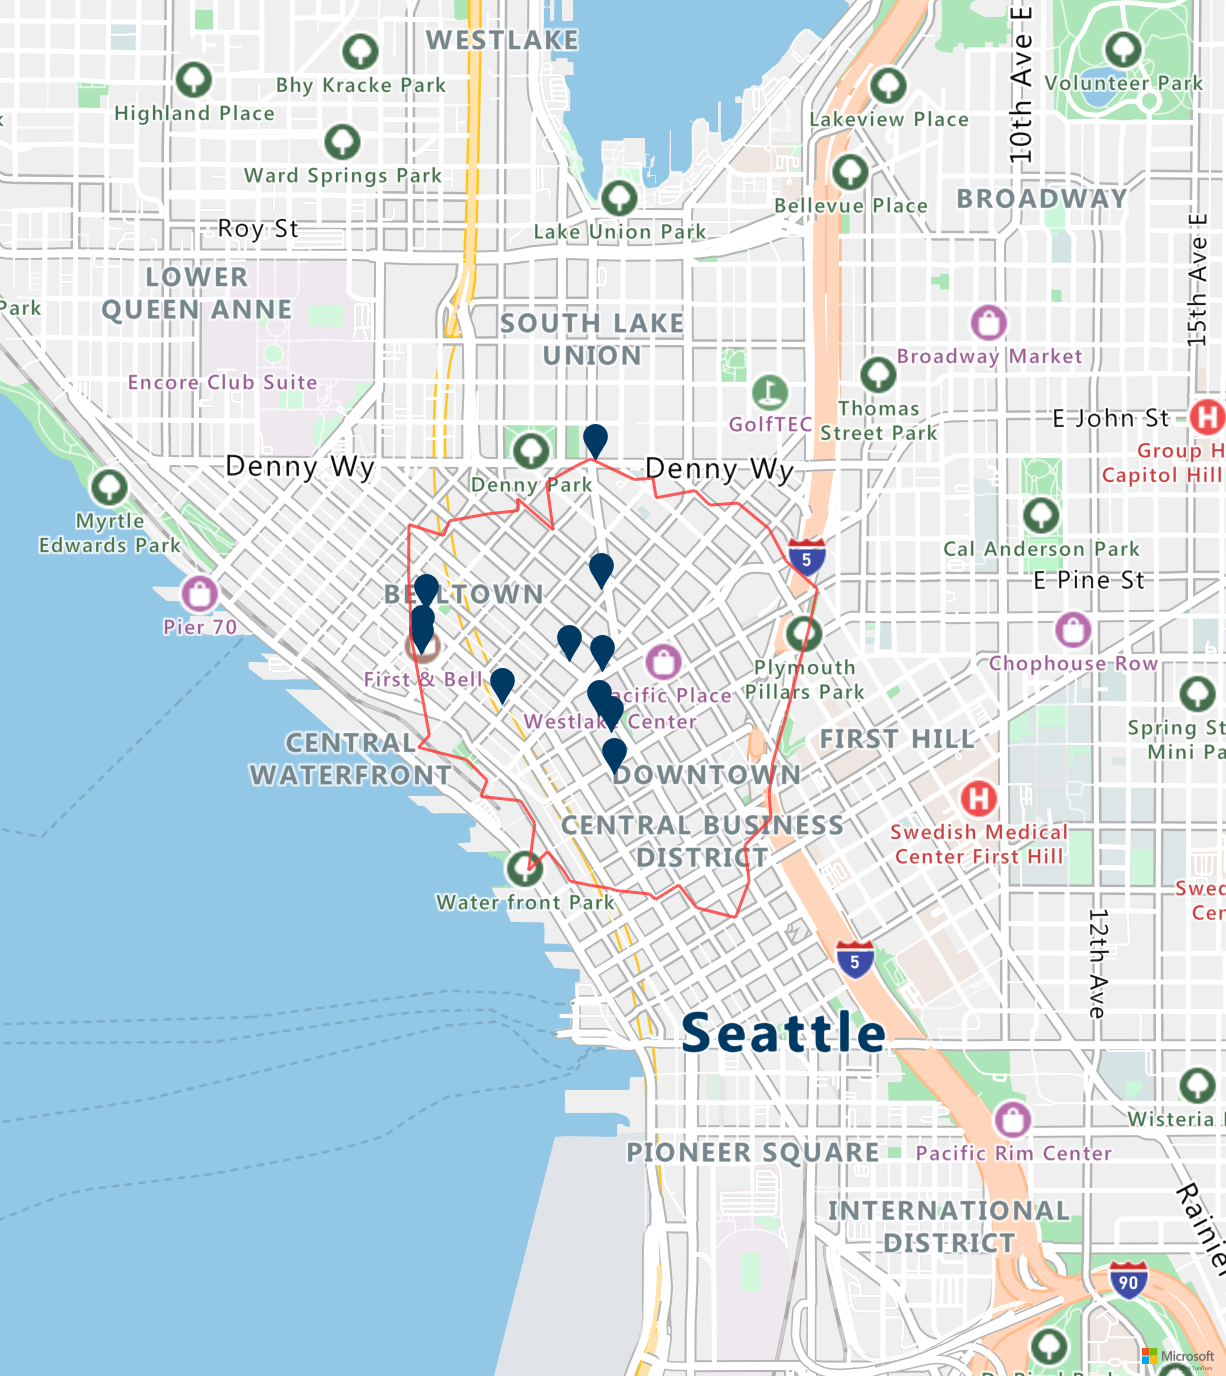

In [60]:
# Get bounds for bounding box.
def getBounds(polyBounds):
    maxLon = max(map(lambda x: x[0], polyBounds))
    minLon = min(map(lambda x: x[0], polyBounds))

    maxLat = max(map(lambda x: x[1], polyBounds))
    minLat = min(map(lambda x: x[1], polyBounds))
    
    lonBuffer = (maxLon-minLon)
    minLon -= lonBuffer
    maxLon += lonBuffer

    latBuffer = (maxLat-minLat)
    minLat -= latBuffer
    maxLat += latBuffer
    
    return [minLon, maxLon, minLat, maxLat]

minLon, maxLon, minLat, maxLat = getBounds(polyBounds)

path = "lcff3333|lw3|la0.80|fa0.35||udid-{}".format(rangeUdid)
pins = "default|an15 53||udid-{}".format(poiUdid)

encodedPins = urllib.parse.quote(pins, safe='')


staticMapResponse = requests.get("https://atlas.microsoft.com/map/static/png?api-version=1.0&subscription-key={}&pins={}&path={}&bbox={}&zoom=14".format(subscriptionKey,encodedPins,path,str(minLon)+", "+str(minLat)+", "+str(maxLon)+", "+str(maxLat)))


poiRangeMap = staticMapResponse.content

display(Image(poiRangeMap))
